In [1]:
import pandas as pd
import dask
dask.config.set(scheduler="processes")
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats
import glob

# Loading the data

In [2]:
signal = "trade"
stock = "MSFT"
market = "B"
markets=["B","C","DF","II","MW","O","OQ","P"]

files = glob.glob(f"./Data/{signal}\\{stock}.{market}\\*.csv.gz")

print(f"signal : {signal},  #files : {len(files)}, stock: {stock}, market:{market}")

def convert_time(df):
    df.index = pd.to_datetime(df["xltime"],unit="d",origin="1899-12-30",utc=True)
    return df
# open_time  = "09:30:00"
# close_time = "16:00:00"
def load_trade_file(file):
    res = pd.read_csv(file,compression="gzip")
    res = convert_time(res)
    res = res[res["trade-stringflag"] == "uncategorized"]
    return res[["trade-price"]]

def load_bbo_file(file):
    res = pd.read_csv(file,compression="gzip").rename(columns={"bid-price":"bid"})
    res = convert_time(res)
    res = res[res.bid>0]
    #res = res.bid.diff(1).dropna()>0 
    return res[["bid"]]

def load_daily_data(date):
    daily_data = {}
    for market in markets:
        try : 
            path = glob.glob(f"./Data/{signal}\\{stock}.{market}\\{date}*.csv.gz")[0]
            daily_data[market] = load_trade_file(path)
        except :
            print(f"missing data : {date} {market}")
    return daily_data

signal : trade,  #files : 251, stock: MSFT, market:B


In [3]:
date = '2010-01-04'
daily_data = load_daily_data(date)

# Signal visu

In [14]:
def generate_delayed_data(s1,s2,delay):
    
    s1.index = s1.index + +pd.Timedelta(milliseconds=delay) 
    pair_data = s1.join(s2,how = "outer",lsuffix="_1",rsuffix="_2").ffill().dropna()
    
    return pair_data


# from https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def compute_correlation(pair_data):
    s1,s2 = pair_data["trade-price_1"].values, pair_data["trade-price_2"].values
    N = len(s1)
    r, p = stats.pearsonr(s1,s2)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r,lo, hi


def visualize_delay(n1,n2,delay,n_samples=1000):
    s1,s2 = daily_data[n1].copy(),daily_data[n2].copy()
    pair_data = generate_delayed_data(s1,s2,delay)[:n_samples]
    corr,_,_      = compute_correlation(pair_data)
    
    plt.plot(pair_data["trade-price_1"])
    plt.plot(pair_data["trade-price_2"])
    plt.title(f"delay:{delay}ms, market1:{n1}, market2:{n2}, corr={corr:0.5f}")
    plt.show()

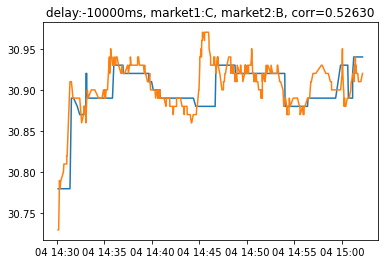

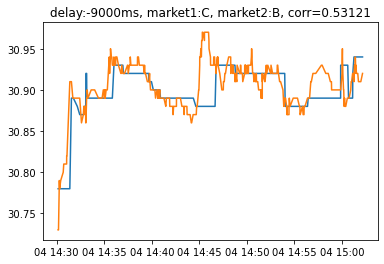

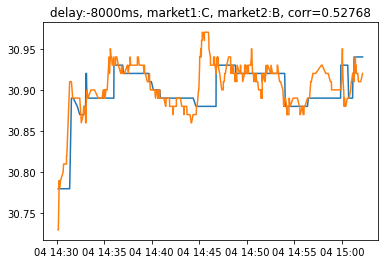

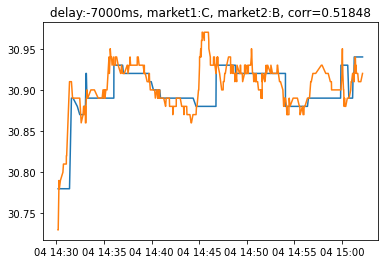

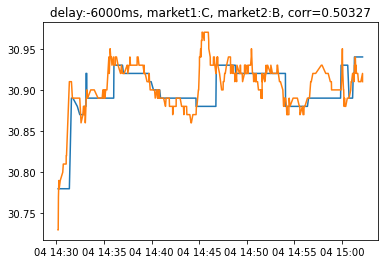

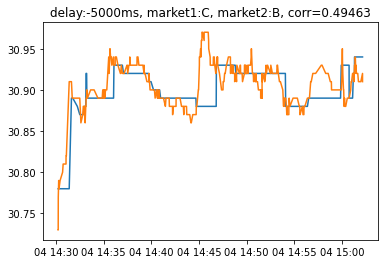

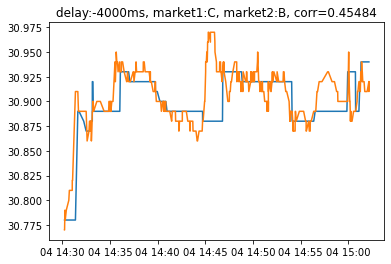

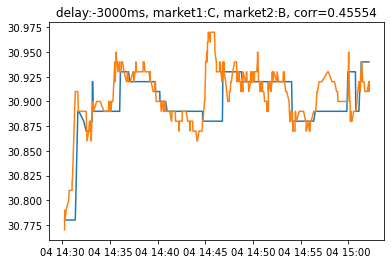

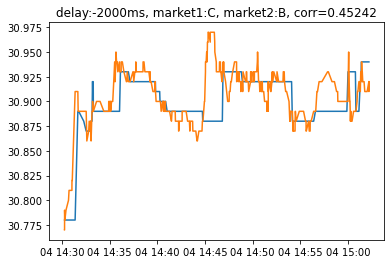

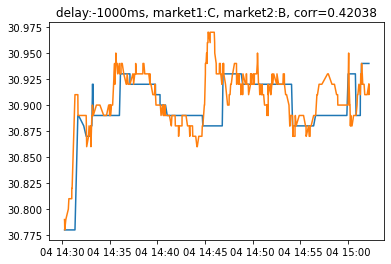

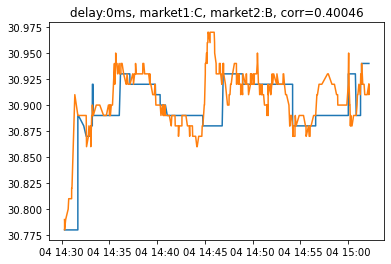

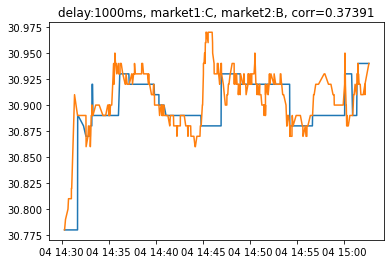

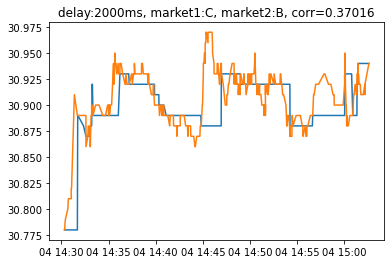

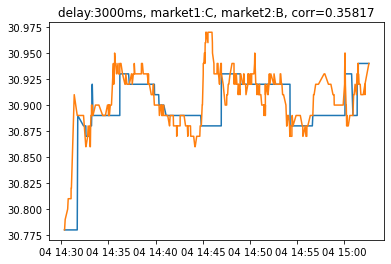

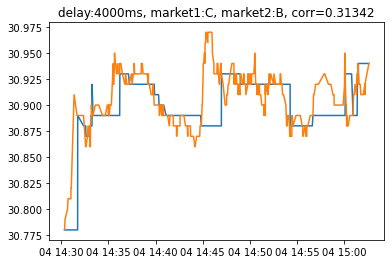

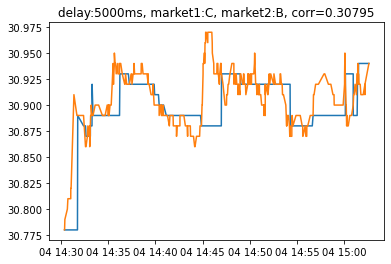

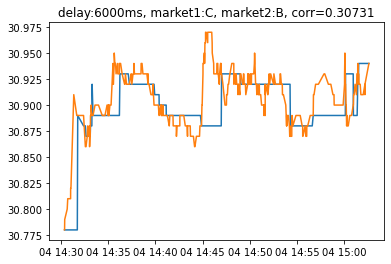

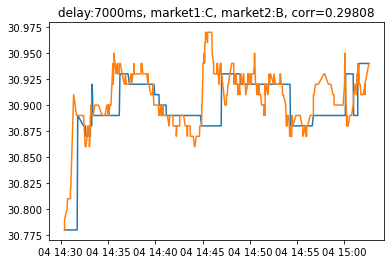

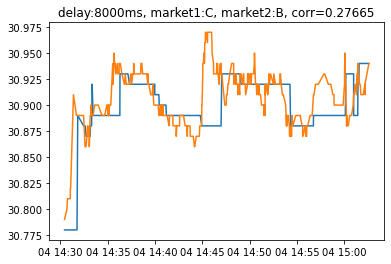

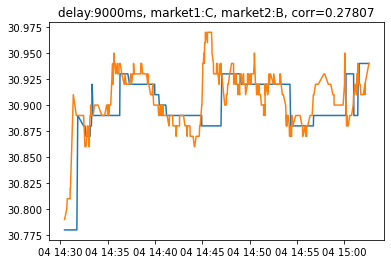

In [99]:
step = 1_000 #ms
delays = range(-10*step,10*step,step)
for delay in delays:
    visualize_delay(n1="C",n2="B",delay=delay)

# Correlation computation

In [76]:
n1,n2  = "C","B"
correlations = []
los=[]
his=[]
step = 1_0 #ms
delays = range(-0*step,10*step,step)
for delay in delays:
    s1,s2 = daily_data[n1].copy(),daily_data[n2].copy()
    pair_data = generate_delayed_data(s1,s2,delay)
    corr,lo,hi      = compute_correlation(pair_data)
    correlations.append(corr)
    los.append(corr-lo)
    his.append(hi-corr)
    

# Visu

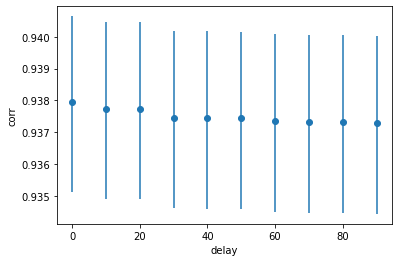

In [80]:
x = list(delays)
y = correlations
errors = [los,his]
plt.errorbar(x, y, yerr=errors, fmt='o')
plt.xlabel("delay")
plt.ylabel("corr")
plt.show()